[単語埋め込み (Word embeddings)  \|  TensorFlow Core](https://www.tensorflow.org/tutorials/text/word_embeddings?hl=ja#%E5%8D%98%E8%AA%9E%E5%9F%8B%E3%82%81%E8%BE%BC%E3%81%BF)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

### Embedding レイヤーを使う

Embedding層に整数を渡すと、埋め込みテーブルのベクトルになる。

In [2]:
# 埋め込みの次元数の設定
embedding_layer = layers.Embedding(1000, 5) # 語彙数, 出力次元数

result = embedding_layer(tf.constant([1,2,3])) # 3つの整数
result.numpy() # 3つのベクトル

array([[ 0.00436724, -0.04417312, -0.03682759,  0.02418276,  0.0432482 ],
       [ 0.03339608,  0.01490796,  0.03961224,  0.00567418, -0.03463871],
       [-0.03721095,  0.010444  , -0.04648114,  0.03209357,  0.02157765]],
      dtype=float32)

返されたテンソルは入力より1つ軸が多くなり、出力次元数が追加される

In [3]:
input_data = tf.constant([[0,1,2],[3,4,5]])
print(input_data.shape)
result = embedding_layer(input_data)
print(result.shape)

(2, 3)
(2, 3, 5)


### 埋め込みを最初から学習する

IMDB の映画レビューの感情分析器

In [4]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

エンコーダーの語彙の一部を確認する（`_` は空白を表す）

In [5]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

シャッフルして、一番長いサンプルに合わせてパディングして、バッチを返す。

In [6]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

### モデルの構築

- Embedding : 整数エンコードされた語彙を、埋め込みベクトルに変換する
- GlobalAveragePooling1D : シーケンスの次元で平均を取り、固定長の出力ベクトルにする

Caution: このモデルはマスキングを使用していません。このため、ゼロパディングが入力の一部として扱われ、結果としてパディングの長さが出力に影響を与える可能性があります。これを修正するには[マスキングとパディング](https://www.tensorflow.org/guide/keras/masking_and_padding?hl=ja)のガイドを参照してください。

In [7]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.Dense(16, activation='relu'),
  layers.GlobalAveragePooling1D(),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
dense (Dense)                (None, None, 16)          272       
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, 
    validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 9s 3ms/step - loss: 0.5644 - accuracy: 0.7382 - val_loss: 0.4433 - val_accuracy: 0.8200
Epoch 2/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3357 - accuracy: 0.8819 - val_loss: 0.3116 - val_accuracy: 0.8850
Epoch 3/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2732 - accuracy: 0.9034 - val_loss: 0.3882 - val_accuracy: 0.8500
Epoch 4/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2441 - accuracy: 0.9168 - val_loss: 0.3460 - val_accuracy: 0.8800
Epoch 5/10
2500/2500 [==============================] - 9s 3ms/step - loss: 0.2204 - accuracy: 0.9246 - val_loss: 0.3491 - val_accuracy: 0.8800
Epoch 6/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.2030 - accuracy: 0.9318 - val_loss: 0.3998 - val_accuracy: 0.8900
Epoch 7/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1911 - accuracy: 0.9363 - val_loss: 0.3094 - val_accuracy

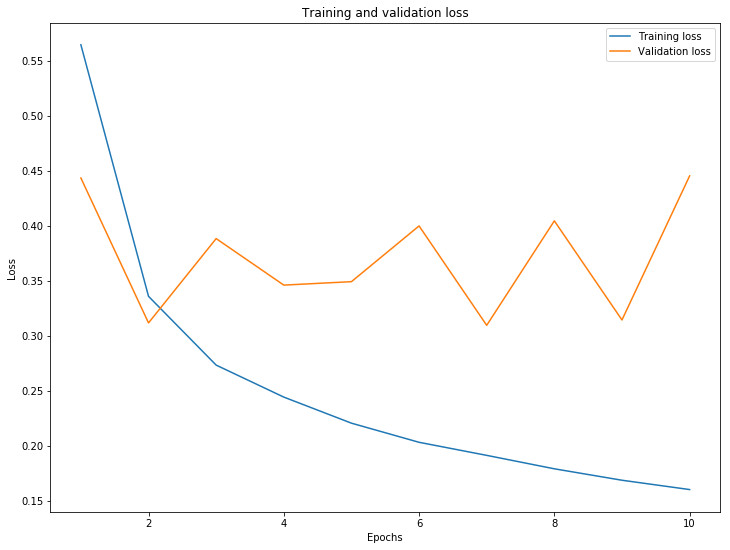

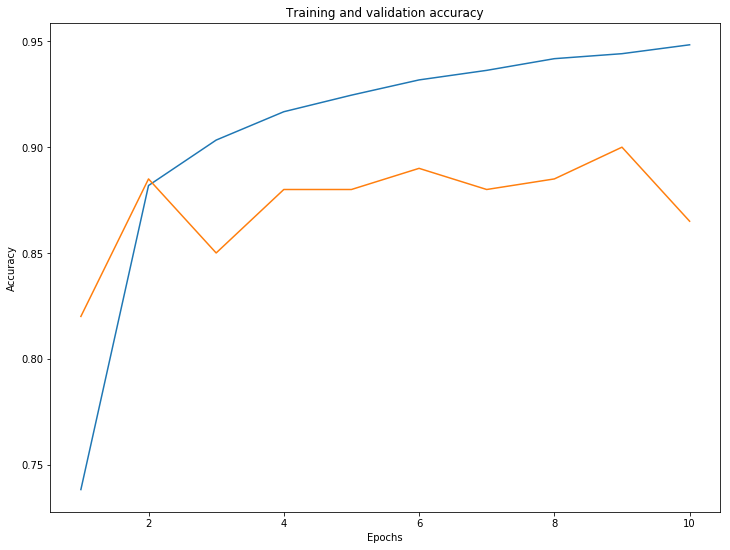

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

モデルは過学習している